# Introduction to Footprints
<br>Owner(s): **Imran Hasan** ([@ih64](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@ih64)), **Second Owner** ([@username2](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@username2))
<br>Last Verified to Run: **2018-11-30**
<br>Verified Stack Release: **16.0**

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Understand Footprints, and their relationship to detection, and measurement
2. Use methods and attributes from the footprint class to get information like centroids, size, shape, of the footprint
3. Perform operations on footprints, like dilation an errosion
4. Use footprints to access pixel level data in their parent exposures

### Logistics
This notebook is intended to be runnable on `lsst-lspdev.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

The next few cells give you some options for your "Set-up" section - you may not need them all.

We'll need the `stackclub` package to be installed. If you are not developing this package, you can install it using `pip`, like this:
```
pip install git+git://github.com/LSSTScienceCollaborations/StackClub.git#egg=stackclub
```
If you are developing the `stackclub` package (eg by adding modules to it to support the Stack Club tutorial that you are writing, you'll need to make a local, editable installation. In the top level folder of the `StackClub` repo, do:

In [1]:
! cd .. && python setup.py -q develop --user && cd -

/home/ishasan/lsst/StackClub/SourceDetection


When editing the `stackclub` package files, we want the latest version to be imported when we re-run the import command. To enable this, we need the %autoreload magic command.

In [2]:
%load_ext autoreload
%autoreload 2

You can find the Stack version that this notebook is running by using eups list -s on the terminal command line:

In [3]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

jld-lab-ishasan-r160
lsst_distrib          16.0+1     	current v16_0 setup


For this tutorial we'll need the following modules:

In [4]:
%matplotlib inline
#%matplotlib ipympl

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import IFrame, display, Markdown

In [5]:
import lsst.daf.persistence as dafPersist
import lsst.daf.base as dafBase

import lsst.afw.math as afwMath
import lsst.afw.geom as afwGeom

import lsst.afw.detection as afwDetect
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
from lsst.meas.algorithms import SourceDetectionTask
from lsst.meas.base import NoiseReplacer, NoiseReplacerConfig
import lsst.afw.detection as afwDetection

import lsst.afw.display as afwDisplay

/opt/lsst/software/stack/stack/miniconda3-4.3.21-10a4fa6/Linux64/meas_mosaic/16.0+1/python/lsst/meas/mosaic/utils.py:30: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use("Agg")


In [6]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)

## Footprints in the DM ecosystem

At a high level, we may think of a Footprint as an object that identifies a collection of pixels which are above threshold. As you might expect, this means Footprints come up often in bread and butter ccdProcessing tasks-like detection, measurement, and deblending-which directly impact science results. Because footprints are so closely related to these very important processes, we will explore them in this notebook.

### The basics

If you are familiar with segmentation maps in `Source Extractor`, you may initially approach Footprints as being somewhat analagous (although we will see Footpritns are much more powerful), as Footprints identify pixels and pixel values on ccds after source detection. This is the perspective we will take in the beginning of our notebook as we introduce the first few attributes and methods of the footprint class. 

In [7]:
# grab some data
# The dafPersist was trying to set the matplotlib backend, catch warning
datadir = "/project/shared/data/Twinkles_subset/output_data_v2"
butler = dafPersist.Butler(datadir)
dataId = {'filter': 'r', 'raft': '2,2', 'sensor': '1,1', 'visit': 235}
calexp = butler.get('calexp', **dataId)
calexp.mask.removeAndClearMaskPlane('DETECTED')

In [8]:
# set up minimal detection task
schema = afwTable.SourceTable.makeMinimalSchema()
config = SourceDetectionTask.ConfigClass()
config.thresholdValue = 10       # detection threshold in units of thresholdType
config.thresholdType = "stdev"   # units for thresholdValue

sourceDetectionTask =   SourceDetectionTask(config=config)

Because we are just interested in interacting with footprints, we will use the `detectFootprints` method in sourceDetectionTask instead of the run method. `detectFootprints` will return a struct to us that deals with footPrints. If we used the run method, we would recieve a struct that included footprints along with a source table, which we do not need for our discussion here. 

In [9]:
# run detection on our frame
detect_res = sourceDetectionTask.detectFootprints(calexp)

`detect_res` is a struct. Struct objects are simmilar to python dictionaries, in that they have key value pairs. However, here you access the values by using the keys as an attribute. If you are and IDL user, these will remind you of Structures in IDL

In [10]:
detect_res

Struct(positive=<lsst.afw.detection._footprintSet.FootprintSet object at 0x7f118e731688>; negative=None; factor=1.0; background=<lsst.afw.math.backgroundList.BackgroundList object at 0x7f118e731780>; numPos=1060; numPosPeaks=1158; numNeg=1; numNegPeaks=1)

Looking at `detect_res`, we can see that there are attributes associated with sources detected positive-that is above threshold, and detected negative. Let us concentrate on the positive detections for now. The positive attribute holds a `FootprintSet`, an object that contains all the positively detected footprints. The `numPos` attribute tells us we have 1060 footprints that were detected positive. The `numPosPeaks` attribute tells us 1158 peaks were detected positive. This is because more than one peak can belong to a footprint.

In [11]:
# lets grab the above threshold footprints that were detected and assign them to a varriable
fpset = detect_res.positive

the variable fpset is a FootprintSet object. While it contains many footprints itself, it does not offer an super easy way to interact with the individual footprints. However, we can ask the FootprintSet to give us a list of footprints, which we can iterate over

In [12]:
fps = fpset.getFootprints()

Now we have drilled our way down to getting our hands on footprints. Lets discuss some of their methods and attributes. First lets meet the basics. You may recognize a few of these as methods on records in `SourceCatalogs` if you did the [afw table guided tour notebook](https://github.com/LSSTScienceCollaborations/StackClub/blob/master/Basics/afw_table_guided_tour.ipynb)

In [13]:
# get the region-the pixel coordinates that describes the chip this footprint belongs too
fps[0].getRegion()

Box2I(minimum=Point2I(0, 0), dimensions=Extent2I(4000, 4072))

In [14]:
# the center of the footprint, in detector coordinates
fps[0].getCentroid()

Point2D(1979.951515, 8.206060606)

In [15]:
# the bounding box of the footprint.
# Not all of the pixels in the bounding box are pixels in the footprint
fps[0].getBBox()

Box2I(minimum=Point2I(1972, 2), dimensions=Extent2I(17, 14))

In [16]:
# area of the footprint. NOTE this is not the area of the bounding box.
# It is the number of pixels associated with the footprint
fps[0].getArea()

165

The footprint's span tells you which pixels in the bounding box belong to the footprint. If an element is zero, this means the pixel is inside the footprint's bounding box but does ot belong to the footprint. If an element is one, the pixel is both in the bounding box and associated with the footprint.

In [17]:
fps[0].getSpans()

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]

### Operations on Footprints

In this next section, we will showcase other properties footprints have that make them more powerful than segmentation maps. We will meet some operations we can perform on footprints, and see how we can use our knowlege of pixel values to calculate properties of footprints.

The quadurpole $Q_{i,j}$ is a matrix containing the second moments, defined in the following way  

$$Q_{i,j} = \int I(x_i, x_j) x_i x_j \mathrm{d}x^i \mathrm{d}x^j$$

Where $I(x_i,x_j)$ is the 2D surface brightness distribution. 
The elements for a footprint can be computed with the getShape() method. Note that the matix is symmetric.

In [18]:
fps[0].getShape()

Quadrupole(ixx=15.088558310376527, iyy=11.70299357208448, ixy=-0.03849403122130394)

We can grow or shrink the PSF using the dilate() and erode() methods. You may imagine doing this if you want to ensure you are getting all the flux associated with the detected source. Using these methods requires that we provide a scale by which to grow or shrink the PSF. Typically, this scale is the $\sigma$ of the gaussian PSF module some factor. Let us demonstrate this below

In [19]:
# first get the gaussian fwhm of the PSF 
psf = calexp.getPsf()
sigma = psf.computeShape().getDeterminantRadius()

# print how many pixels belong to the footprint before we dilate it
print('before dilating the footprint has an area of {}'.format(fps[0].getArea()))

# now we will grow the footprint by 2 x sigma. We need pass an int
fps[0].dilate(int(2*sigma))

# print how many pixels belong to the footprint ater dilation
print('after dilating the footprint has an area of {}'.format(fps[0].getArea()))

before dilating the footprint has an area of 165
after dilating the footprint has an area of 378


In [20]:
# lets chip away at the footprint by using the erode method now
fps[0].erode(int(2*sigma))

# print how many pixels belong to the footprint ater dilation
print('after eroding the footprint has an area of {}'.format(fps[0].getArea()))

after eroding the footprint has an area of 165


Now we will turn our footprint into a `HeavyFootprint`. This means the footprints now 'know' about the pixel values for each pixel they are associated with. 

In [21]:
# first we domonstrate the footprint is not heavy
fps[0].isHeavy()

False

In [22]:
# we will make all the footprins heavy at the same time by operating on the footprint set
fpset.makeHeavy(calexp.getMaskedImage())
# we have to redefine fps
fps = fpset.getFootprints()

In [23]:
# prove the footprints are now indeed heavy
fps[0].isHeavy()

True

The Heavy Footprints know about the maskedImage from the parent calexp, ansd subsequently know about the variance, mask, and image planes from the parent calexp

In [24]:
# all of the arrays here will be flattend 1D arrays of pixels from the footprint
fps[0].getImageArray()

array([-9.84372520e+00,  8.15535069e+00,  1.51543646e+01, -2.48465633e+01,
       -2.38474941e+01,  1.81515770e+01, -1.84929299e+00,  4.71567116e+01,
        7.01557922e+01,  1.91548634e+01,  4.21539383e+01, -1.18469896e+01,
        3.21520805e+01,  3.21511536e+01,  3.21502190e+01,  3.51492882e+01,
       -1.48427954e+01,  4.15628195e+00, -1.98447018e+01, -1.58456259e+01,
        6.21534500e+01,  4.11525192e+01,  4.41515923e+01,  7.11506653e+01,
       -3.85026836e+00,  9.14879990e+00, -3.08520737e+01, -3.08423080e+01,
        3.41567078e+01, -3.18442116e+01,  3.01548653e+01,  5.71539459e+01,
        6.11529541e+01,  7.11520309e+01,  1.07151100e+02,  7.21501694e+01,
       -1.18506994e+01,  5.61483650e+01,  2.01474323e+01, -4.38534393e+01,
        4.15811348e+00,  2.31571960e+01,  1.01562738e+01,  2.01552944e+01,
        3.21543694e+01,  7.01534424e+01,  1.66152512e+02,  1.03151596e+02,
        7.41506653e+01,  1.33149734e+02,  3.41488037e+01,  1.21478720e+01,
        3.81470032e+01,  

In [25]:
fps[0].getMaskArray()

array([48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48,
       48, 48, 48, 48, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32], dtype=int32)

In [26]:
calexp.getMask().getMaskPlaneDict()

{'BAD': 0,
 'CR': 3,
 'DETECTED': 5,
 'DETECTED_NEGATIVE': 6,
 'EDGE': 4,
 'INTRP': 2,
 'NO_DATA': 8,
 'SAT': 1,
 'SUSPECT': 7}

In [27]:
fps[0].getVarianceArray()

array([ 811.,  829.,  836.,  796.,  797.,  839.,  819.,  868.,  891.,
        840.,  863.,  809.,  853.,  853.,  853.,  856.,  806.,  825.,
        801.,  805.,  883.,  862.,  865.,  892.,  817.,  830.,  790.,
        790.,  855.,  789.,  851.,  878.,  882.,  892.,  928.,  893.,
        809.,  877.,  841.,  777.,  825.,  844.,  831.,  841.,  853.,
        891.,  987.,  924.,  895.,  954.,  855.,  833.,  859.,  861.,
        838.,  813.,  821.,  842.,  834.,  821.,  908.,  908.,  986.,
       1032., 1018.,  909.,  920.,  801.,  831.,  853.,  779.,  816.,
        828.,  860.,  866.,  851.,  854.,  887.,  957.,  995.,  999.,
        996.,  942.,  879.,  855.,  838.,  809.,  788.,  799.,  826.,
        820.,  814.,  874.,  860.,  883.,  884.,  962.,  984., 1001.,
        904.,  849.,  828.,  854.,  843.,  749.,  820.,  810.,  850.,
        799.,  821.,  892.,  918.,  914.,  906.,  847.,  822.,  820.,
        824.,  854.,  854.,  772.,  846.,  848.,  843.,  890.,  837.,
        870.,  836.,

### Footprints, Calexps, and Src catalogs

As we mentioned at the start of our notebook, footprints work hand in hand with detection and measurement. To demonstrate how this happens in processCCD.py, we will use the calexps, src catalog, and footprints to replace all footprints with noise, and then put footprints back individually.

In [68]:
# lets grab the calexp and source catalog for our dataId
calexp = butler.get('calexp', **dataId)
cat = butler.get('src', **dataId)

In [69]:
# We will sort the source catalog and grab the object that has the brightest psf flux
cat.sort(cat.getPsfFluxKey())
cat = cat.copy(deep=True)

In [70]:
# Find the centroid of this source so we can visualize it in a few steps
cat[0].getCentroid()

Point2D(2681, 2974)

In [72]:
# Lets grab the parent ID of this source. The deblende can shread sources sometimes
# If we grab the parent, we can ensure we have a bright noticable source to visualize
cat[0].getParent()

1010357503384

Before we start playing around with swapping footprints in and out of the frame, lets take a look at the calexp as it is. We can see a nice bright source at the center, along with a few fainter sources in the background

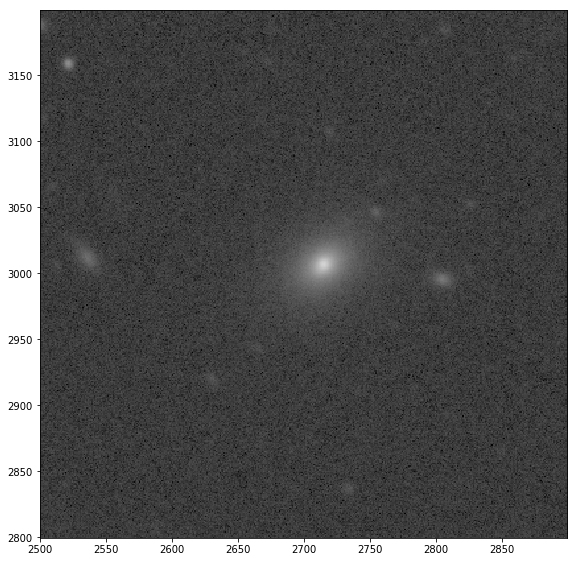

In [73]:
afwDisplay.setDefaultBackend('matplotlib') 

afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage()[2500:2900,2800:3200])

Now we will see how we can exchange the detection footprints with noise by using the NoiseReplacer object. We will emulate steps that are taken in SingleFrameMeasurement Task, where measurement algorithms are run on sources. The next two cells are inspired by a few lines from [sfm.py](https://github.com/lsst/meas_base/blob/master/python/lsst/meas/base/sfm.py#L305). We will first need to organize our footprints into a dictionary, where the sourceId's are the keys and the associated value pairs are the footprints themselves.

We will also point out here that you can grab footprints right from the source catalog

In [74]:
# prepare footprints in dictionary
fp_dict = {measRecord.getId(): (measRecord.getParent(), measRecord.getFootprint())
                      for measRecord in cat}

In [75]:
# instantiate NoiseReplacer. show it our calexp and footprints
nr_config = NoiseReplacerConfig()
noiseReplacer = NoiseReplacer(nr_config, calexp, fp_dict)

As we create the `noiseReplacer` object, noise properties are calculated using the pixel values whose associated mask plane pixels have not been set. This noise distribution is used to replace the footprints with generated noise that is supposed to be representative of the true noise properties of the calexp. Now we will display the calexp again to see the result.

<Figure size 576x576 with 0 Axes>

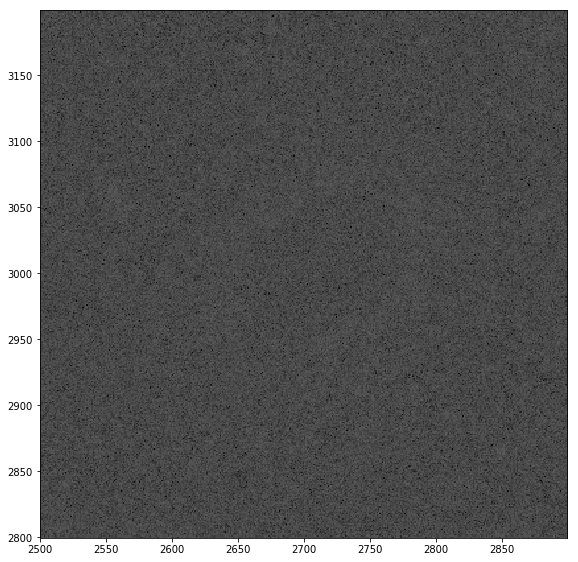

In [76]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage()[2500:2900,2800:3200])

As advertised, we swapped out the data in our footprints with noise. Now we will draw some more insperation from [sfm.py](https://github.com/lsst/meas_base/blob/master/python/lsst/meas/base/sfm.py#L353) where we will insert our favorite bright source back into the image using its ID from the source catalog.

In [77]:
noiseReplacer.insertSource(1010357503384)

<Figure size 576x576 with 0 Axes>

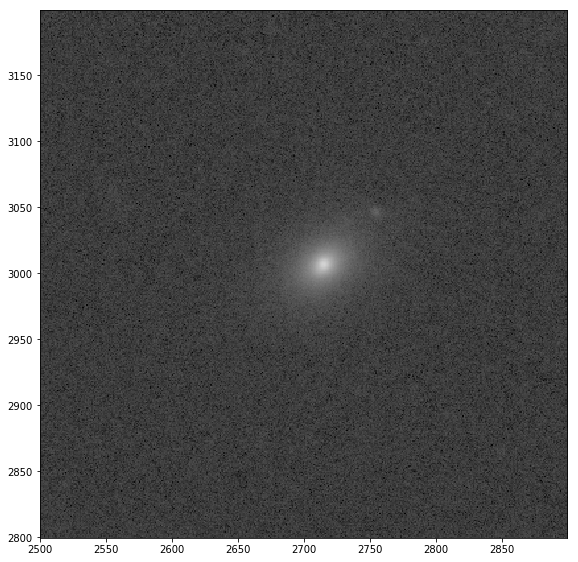

In [78]:
plt.figure()
afw_display = afwDisplay.Display()
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(calexp.getMaskedImage()[2500:2900,2800:3200])

Right now, this source is the only source in the image. Measurement algorithms would be ran on the image in this setting to obtain measurements for this source ID. After that, it will be replaced again with noise, and the next footprint will be filled back in to have its measurements taken, and so on and so forth.

### TO DO

what happens to footprints after deblending

### TO DO 

Say something about Peaks, and deblending

### TO DO

single vist vs coadds

## Summary

Remind the user what they have done, and what they should now be able to do.

In [33]:
2**5

32

You could also point them to a related tutorial or reference source, to help them go further.